In [1]:
from autoplanner import AutoPlanner
from mysession import production

ImportError: cannot import name 'AutoPlanner' from 'autoplanner' (/Users/justinvrana/Documents/GitHub/Terrarium/autoplanner/__init__.py)

In [2]:
ap = AutoPlanner(production, depth=500)

In [3]:
ap.set_verbose(False)
ap.construct_template_graph()

2018-11-15 08:41:20,565 - Browser@http://52.27.43.242/ - ERROR - INCONSISTENT AQUARIUM DATABASE - There where 2 missing AllowableFieldType models from the Aquarium database, which were ignored by trident. This happens when models are deleted from Aquarium which results in an inconsistent server database. Trident was unable resolve the following relationships which returned no models from the server: AllowableFieldType.where(id=[87, 87])
2018-11-15 08:41:37,285 - Browser@http://52.27.43.242/ - ERROR - INCONSISTENT AQUARIUM DATABASE - There where 1 missing FieldValue models from the Aquarium database, which were ignored by trident. This happens when models are deleted from Aquarium which results in an inconsistent server database. Trident was unable resolve the following relationships which returned no models from the server: FieldValue.where(id=[585701])
2018-11-15 08:41:39,133 - Browser@http://52.27.43.242/ - ERROR - INCONSISTENT AQUARIUM DATABASE - There where 1 missing AllowableField

Example edges

input <AllowableFieldType sample_type={'rid': 62246, 'id': 5, 'name': 'Yeast Strain', 'description': 'A strain of yeast distinguished from others by genomic or plasmid modifications', 'created_at': '2013-10-16T14:37:29.000-07:00', 'updated_at': '2015-12-08T17:40:57.000-08:00'} object_type={'rid': 62237, 'id': 797, 'name': '96 Well PCR Plate', 'description': 'A 96 Well plate that can fit into a thermocycler.', 'min': 0, 'max': 1, 'handler': 'collection', 'safety': 'No safety information', 'cleanup': 'No cleanup information', 'data': 'No data', 'vendor': 'No vendor information', 'created_at': '2018-08-03T18:10:19.000-07:00', 'updated_at': '2018-08-03T18:49:13.000-07:00', 'unit': 'plate', 'cost': 0.01, 'release_method': 'return', 'release_description': '', 'sample_type_id': 5, 'image': '', 'prefix': '', 'rows': 8, 'columns': 12} rid=61243>
output <AllowableFieldType sample_type={'rid': 62246, 'id': 5, 'name': 'Yeast Strain', 'description': 'A strain of yeast distinguished f

In [7]:
wc = ap.weight_container

wires = wc.collect_wires(wc.plans)
operations = wc.collect_operations(wc.plans)

edges = wc.to_edges(wires, operations)

In [8]:
from collections import Counter
import functools

class HashCounter(Counter):

    def __init__(self, data=(), hash_function=None):
        self.hash_function = hash_function
        super().__init__()
        for d in data:
            self[d] += 1

    def by_attrs(self, *attrs):
        self.hash_function = functools.partial(self.hash_by_attributes, attributes=attrs)
        return self

    @staticmethod
    def hash_by_attributes(data, attributes=()):
        return "%".join([str(getattr(data, x, None)) for x in attributes])

    def __setitem__(self, k, v):
        return super().__setitem__(self.hash_function(k), v)

    def __getitem__(self, k):
        return super().__getitem__(self.hash_function(k))

class HashCounterView(object):
    
    def __init__(self, data):
        self.data = data
        self.counters = {}
    
    def register(self, name, function):
        new_counter = HashCounter(self.data, hash_function=function)
        self.counters[name] = new_counter
        return new_counter
        
    def __getitem__(self, key):
        return self.counters[key]
    
    def __setitem__(self, key, val):
        return self.register(key, val)
        

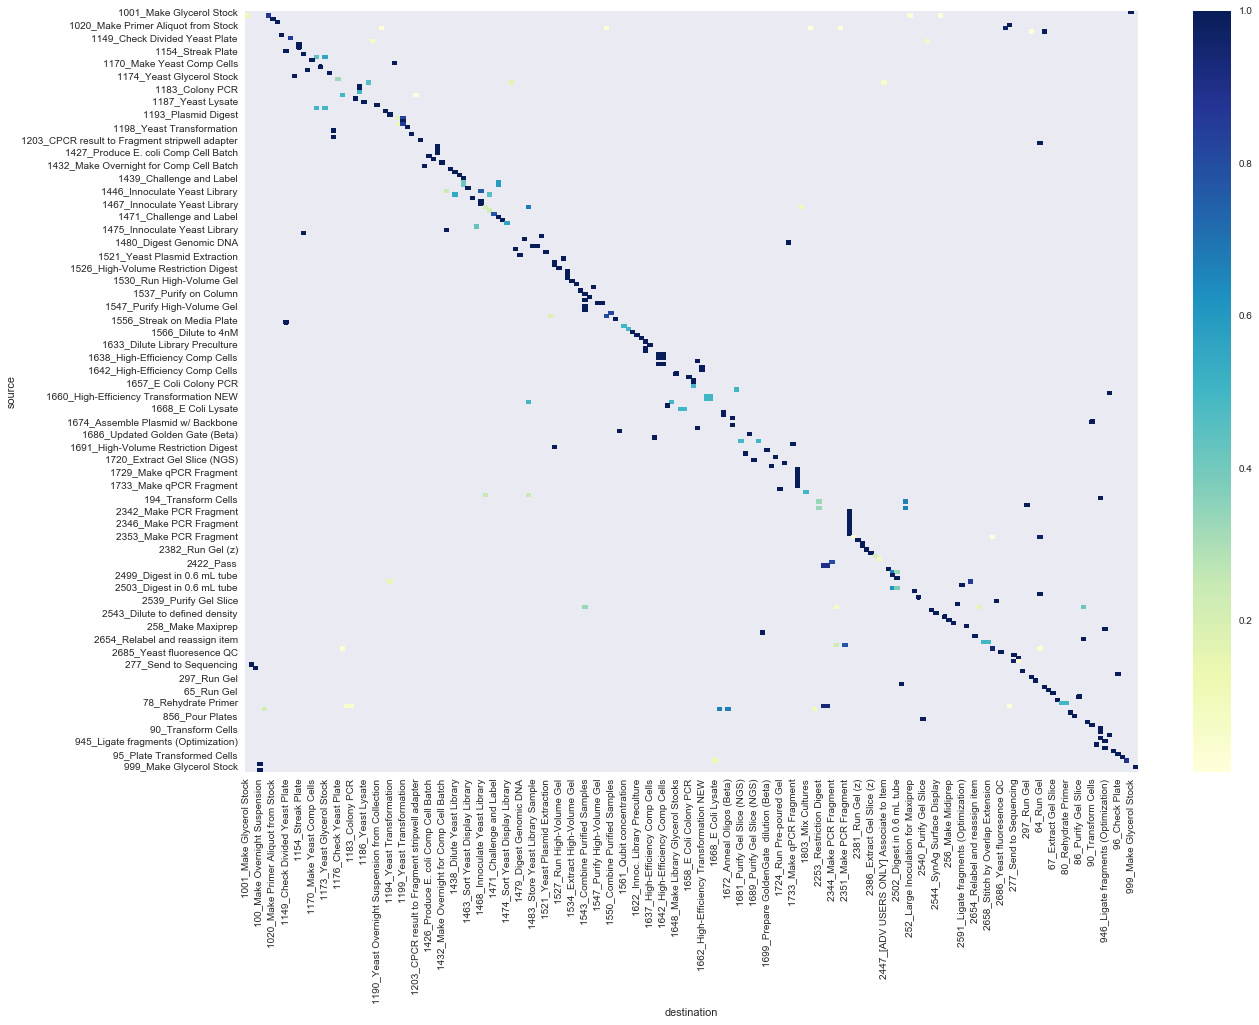

In [27]:
%matplotlib inline

from collections import defaultdict
from uuid import uuid4
import pylab as plt
import seaborn as sns
import pandas as pd


def external_aft_hash(aft):
    """A has function representing two 'extenal' :class:`pydent.models.AllowableFieldType` models (i.e. a wire)"""
    if not aft or not aft.field_type:
        return str(uuid4())
    if aft.field_type.part:
        part = True
    else:
        part = False
    return "{optype}-{object_type}-{sample_type}-{part}".format(
            optype=aft.field_type.operation_type.id,
            object_type=aft.object_type_id,
            sample_type=aft.sample_type_id,
            part=part,
    )

def myhash(pair):
    return "{}->{}".format(external_aft_hash(pair[0]), external_aft_hash(pair[1]))

# def groupby(iterable, key=None):
#     grouped = defaultdict(list)
#     for d in iterable:
#         grouped[key(d)].append(d)
#     return grouped

counter = HashCounter(hash_function=myhash)
node_counter = HashCounter(hash_function=external_aft_hash)
for n1, n2 in edges:
    counter[(n1,n2)] += 1
    node_counter[n1] += 1
    
rows = []
for n1, n2 in edges:
    if n1 and n2:
        rows.append({
            "source": "{}_{}".format(n1.id, n1.field_type.operation_type.name),
            "destination": "{}_{}".format(n2.id, n2.field_type.operation_type.name),
            "count": counter[(n1, n2)],
            "total": node_counter[n1],
        }
    )

df_long = pd.DataFrame(rows)
df_long.drop_duplicates(inplace=True)
df_long['weight'] = df_long['count'] / df_long['total']
df_long.sort_values(by=['weight'], inplace=True, ascending=True)
df = df_long.iloc[:].pivot("source", "destination", "weight")
df

# # df.fillna(0, inplace=True)
sns.set()
f, ax = plt.subplots(figsize=(20, 14))
sns.heatmap(df, annot=False, ax=ax, cmap="YlGnBu")
plt.savefig("/Users/justinvrana/Desktop/all_op_types.pdf", format="pdf")

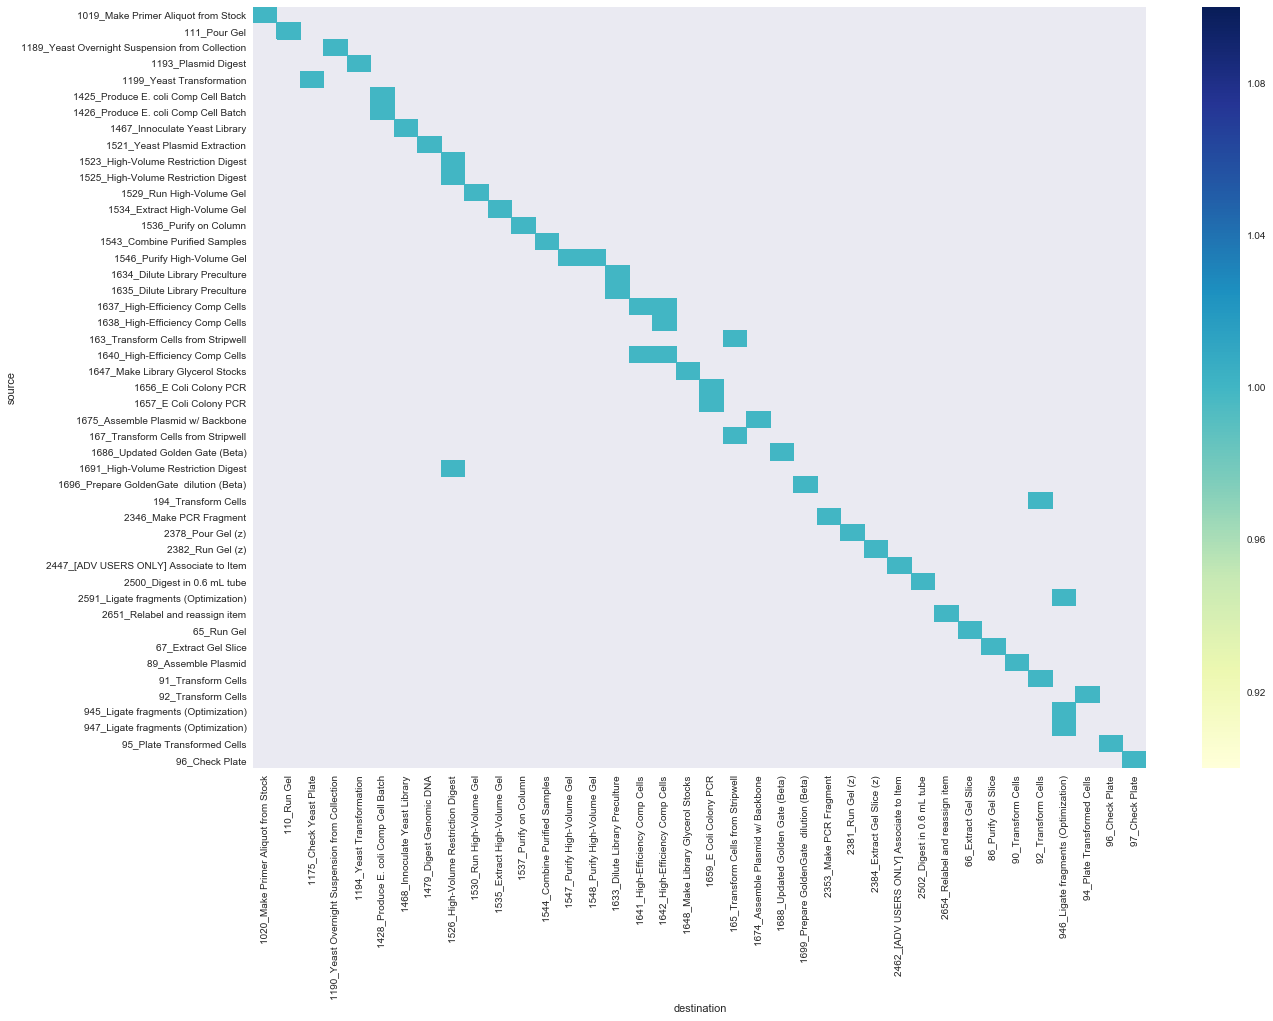

In [26]:
df_long.sort_values(by=['weight'], inplace=True, ascending=True)
df = df_long.iloc[:].pivot("source", "destination", "weight")
df

# # df.fillna(0, inplace=True)
sns.set()
f, ax = plt.subplots(figsize=(20, 14))
sns.heatmap(df, annot=False, ax=ax, cmap="YlGnBu")

# plt.savefig("/Users/justinvrana/Desktop/top_50_optypes.pdf", format="pdf")

In [44]:
import math
x = 
(1-x)/(1+x)

0.0

In [37]:
df_long

count                                      destination  \
2802       1                          2666_Fragment Analyzing   
4051       1   1203_CPCR result to Fragment stripwell adapter   
5852       1                                  1964_Send Email   
4864       1                           2346_Make PCR Fragment   
991        1               254_Large Inoculation for Midiprep   
7054       4                                      298_Run Gel   
5804       3                              1192_Plasmid Digest   
42         2                           273_Send to Sequencing   
4769       4               252_Large Inoculation for Maxiprep   
4568       6                    1549_Combine Purified Samples   
6860      10                           278_Send to Sequencing   
4052       7                                  1182_Colony PCR   
5535       7                                  1183_Colony PCR   
2256      15          2447_[ADV USERS ONLY] Associate to Item   
1710       2                   2542_Dilute to defined density   
5168       2  1189_Yeast Overnight Suspension from Collection   
2304      15                           2345_Make PCR Fragment   
2317       1                                       64_Run Gel   
1614       1                          1181_Fragment Analyzing   
9296       2                                        2428_Pass   
771        6                                1802_Mix Cultures   
2773       1                                  1972_Send Email   
3531      30                               1668_E Coli Lysate   
4847       1                        1194_Yeast Transformation   
125       42                         1001_Make Glycerol Stock   
23        54                  1476_Yeast Overnight Suspension   
1531      32                 2655_Stitch by Overlap Extension   
7661      19                        1198_Yeast Transformation   
4574       6              1523_High-Volume Restriction Digest   
6745       1                  1160_Yeast Overnight Suspension   
...      ...                                              ...   
6843     357                           277_Send to Sequencing   
6842      10                                  857_Pour Plates   
6841      68                  1162_Yeast Overnight Suspension   
6829     247                                102_Make Miniprep   
4482       6                         1527_Run High-Volume Gel   
4483       6                     1534_Extract High-Volume Gel   
4484       6                      1546_Purify High-Volume Gel   
4487       6                         1528_Run High-Volume Gel   
4572      94                    1543_Combine Purified Samples   
4767       4              1691_High-Volume Restriction Digest   
4768       4                                258_Make Maxiprep   
4776       1                     99_Make Overnight Suspension   
4861       1                                   96_Check Plate   
4925      12                  1686_Updated Golden Gate (Beta)   
5167       2                   1149_Check Divided Yeast Plate   
7741      70                        1478_Treat With Zymolyase   
5642       7             2591_Ligate fragments (Optimization)   
6790     208                       95_Plate Transformed Cells   
6791     194                               92_Transform Cells   
6792     204                               92_Transform Cells   
6805     505                              89_Assemble Plasmid   
6809      46                  1172_Inoculate Yeast Comp Cells   
6810      37                       1170_Make Yeast Comp Cells   
6811      79                        1174_Yeast Glycerol Stock   
6812      68                  1162_Yeast Overnight Suspension   
6816     324                                  1185_Colony PCR   
6817     324                                  1185_Colony PCR   
6819      89                              1193_Plasmid Digest   
6789     223                                   97_Check Plate   
16811      5         1699_Prepare GoldenGa

In [ ]:
afts_long = []


In [309]:
flights_long = sns.load_dataset("flights")
flights_long.pivot("month", "year", "passengers")

year       1949  1950  1951  1952  1953  1954  1955  1956  1957  1958  1959  \
month                                                                         
January     112   115   145   171   196   204   242   284   315   340   360   
February    118   126   150   180   196   188   233   277   301   318   342   
March       132   141   178   193   236   235   267   317   356   362   406   
April       129   135   163   181   235   227   269   313   348   348   396   
May         121   125   172   183   229   234   270   318   355   363   420   
June        135   149   178   218   243   264   315   374   422   435   472   
July        148   170   199   230   264   302   364   413   465   491   548   
August      148   170   199   242   272   293   347   405   467   505   559   
September   136   158   184   209   237   259   312   355   404   404   463   
October     119   133   162   191   211   229   274   306   347   359   407   
November    104   114   146   172   180   203   237   271   305   310   362   
December    118   140   166   194   201   229   278   306   336   337   405   

year       1960  
month            
January     417  
February    391  
March       419  
April       461  
May         472  
June        535  
July        622  
August      606  
September   508  
October     461  
November    390  
December    432

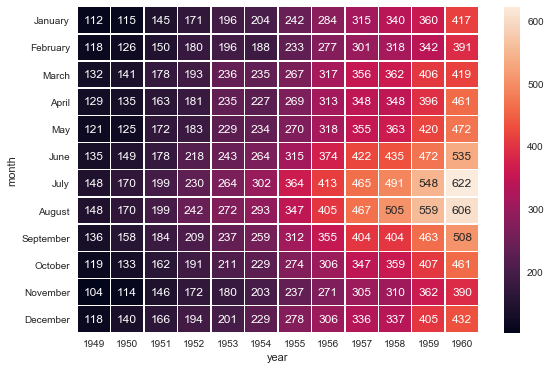

In [293]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load the example flights dataset and conver to long-form
flights_long = sns.load_dataset("flights")
flights = flights_long.pivot("month", "year", "passengers")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(flights, annot=True, fmt="d", linewidths=.5, ax=ax)

In [33]:
ops = ap.weight_container.collect_operations(ap.weight_container.plans)
wc = ap.weight_container
wires = wc.collect_wires(wc.plans)
operations = wc.collect_operations(wc.plans)
edges = wc.to_edges(wires, operations)
# set([op.operation_type.name for op in ops])

In [ ]:
dict()

In [296]:
from collections import Counter
import functools

class HashCounter(Counter):

    def __init__(self, data=(), hash_function=None):
        self.hash_function = hash_function
        super().__init__()
        for d in data:
            self[d] += 1

    def by_attrs(self, *attrs):
        self.hash_function = functools.partial(self.hash_by_attributes, attributes=attrs)
        return self

    @staticmethod
    def hash_by_attributes(data, attributes=()):
        return "%".join([str(getattr(data, x, None)) for x in attributes])

    def __setitem__(self, k, v):
        return super().__setitem__(self.hash_function(k), v)

    def __getitem__(self, k):
        return super().__getitem__(self.hash_function(k))

class HashCounterView(object):
    
    def __init__(self, data):
        self.data = data
        self.counters = {}
    
    def register(self, name, function):
        new_counter = HashCounter(self.data, hash_function=function)
        self.counters[name] = new_counter
        return new_counter
        
    def __getitem__(self, key):
        return self.counters[key]
    
    def __setitem__(self, key, val):
        return self.register(key, val)
        
hashview = HashCounterView([1,2,3,3,2,1,2,3])
hashview.register('bystr', lambda x: str(x))
hashview.register('byid', lambda x: id(x))
hashview['bystr']
hashview['byid']

HashCounter({4557157712: 2, 4557157744: 3, 4557157776: 3})

In [242]:
c = HashCounter(hash_function=lambda x, y: x*y)
c[1,2] += 1

TypeError: <lambda>() missing 1 required positional argument: 'y'

In [205]:
class HashView(object):
    
    def __init__(self, data):
        self.data = data
        self.counters = {}
    
    def register(self, name, function):
        new_counter = HashCounter(self.data, hash_function=function)
        self.counters[name] = new_counter
        return new_counter
        
    def __getitem__(self, key):
        return self.counter[key]
    
    def __setitem__(self, key, val):
        return self.register(key, val)
        
hashview = HashView([1,2,3,3,2,1,2,3])
hashview['bystr'] = lambda x: str(x)

AttributeError: 'HashCounter' object has no attribute 'hash_function'

In [187]:
c = Counter()
for f in [foo, foo2, foo3, foo4]*10000:
    c[hasher.function(f)] += 1

In [54]:
fvs = list(ap.browser.model_cache['FieldValue'].values())
fv = fvs[0]
schema = fv.model_schema(many=True)
data = schema.dump(fvs[:100])
pass

In [65]:
import json
import dill as pickle
from mysession import production
for fv in fvs[:10]:
    data = json.loads(json.dumps(fvs[0].__dict__, default=lambda o: None))
    fv2 = production.FieldValue.load(data)
    print(fv2.dump())

{'_session': <AqSession(name=None, AqHTTP=<AqHTTP(vrana, http://52.27.43.242/)>))>, 'column': None, 'value': None, 'container': None, 'id': 885688, 'created_at': '2018-10-23T20:47:59.000-07:00', 'child_sample_name': None, 'parent_class': 'Operation', 'rid': 28242, 'child_sample_id': None, 'raw': {'wires_as_dest': [], 'allowable_field_type': None, 'item': None, 'operation': None, 'parent_sample': None, 'sample': None, 'field_type': None, 'wires_as_source': [], 'column': None, 'row': None, 'role': 'input', 'id': 885688, 'name': 'Genetic Material', 'parent_class': 'Operation', 'parent_id': 257437, 'child_sample_id': None, 'child_item_id': None, 'field_type_id': 6615, 'allowable_field_type_id': 3817, 'value': None, 'container': None, '_session': None, '_rid': 5954, 'rid': 3364, 'loaded_fields': {'wires_as_dest': None, 'child_sample_name': None, 'allowable_field_type': None, 'allowable_child_types': None, 'item': None, 'operation': None, 'array': None, 'parent_sample': None, 'sid': None, 's

In [5]:
ap.search_graph(None, nursery.ObjectType.find_by_name("Yeast Glycerol Stock"), nursery.ObjectType.find_by_name("Fragment Stock"))


**************************************************
Fragment Stock >> Yeast Glycerol Stock
**************************************************

166671.11096297397


UnboundLocalError: local variable 'aft' referenced before assignment

In [10]:
from copy import deepcopy, copy



In [ ]:
import dill as pickle
with open('temp.pkl', 'wb') as f:
    pickle.dump(ap, f)

In [ ]:
with open('temp.pkl', 'rb') as f:
    session = pickle.load(f)

In [ ]:
session

In [21]:
import sys
sys.getsizeof(ap)

56

In [22]:
ap